# Midterm Assignment, topic 2: Cobweb model of market equilibrium

> The sequence of tasks below should be performed in order in this
notebook. Feel free to add code and markdown cells, but do not change
cells that contain the assignment tasks.
If the task offers some degree of interpretation (so, don’t tell you what
to do exactly), you are free to interpret it in the way you see fit
best. But remember to explain why you make such and such choice in your answer.

> The grade for the midterm assignment is based on both the code
correctness and code style. The former relates to whether the code
adequately represents the economic model under consideration, and the
latter has to do with how well the code is modularized and organized,
whether appropriate syntax is used, and whether the code is well
documented. [PEP 8](https://www.python.org/dev/peps/pep-0008/)
standard is a good reference for coding style, but will not reduce the
grade.

## Cobweb model of market equilibrium

In this assignment you implement on a computer an early dynamic model of
market equilibrium which features price and quantity fluctuations that
are evident in slow moving markets, for example, live stock or other
agricultural markets.

- M Ezekiel “The cobweb theorem”, The Quarterly Journal of Economics,
  1938  
- [https://en.wikipedia.org/wiki/Cobweb_model](https://en.wikipedia.org/wiki/Cobweb_model)  


The main mechanism of the model is that price taking firms base their production
decision on previous period market prices (naive expectations),
while consumers base their decisions on how much to consume based on the
current market price.

Consider an economy with only one good. Given any time period $ t $,
the supply curve features a one period lag in response to the market
price: at period $ t $, producers choose to produce
$ Q_t = Q^S(P_{t-1}) $. As such, the amount produced in period
$ t $, $ Q_t $, is chosen before current prices are observed.
Given the quantity chosen by producers, current prices $ P_t $ are
subsequently determined from the willingness to pay or from the market
demand curve of consumers: $ P_t = P(Q_t) $, where $ P(Q_t) $ denotes
the inverse demand curve.
The dynamics of the model is then represented by a sequence

$$
P_{t-1} \rightarrow Q_t \rightarrow P_t \rightarrow Q_{t+1} \rightarrow \dots
$$

### Task 1. Design and implement a Python class to represent the model

- Represent supply and (inverse?) demand curves by two separate methods. For both
  implement the following functional forms, each with the appropriate
  number of parameters and parameter restriction to ensure upwards
  sloping supply and downwards sloping demand curves:  
  - linear form $ y=ax+b $  
  - exponential of the general form $ y=a\exp(bx+c)+d $  
  - logarithmic of the general form $ y=a\log(bx+c)+d $  
- Design the attributes of the class and implement *init* and *repr*
  methods. Implement *supply*, *demand*, and other methods according to your design.  
- Write a *solve* method which would numerically solve for market
  equilibrium in the model by finding the point on the price-quantity
  plane where supply equals demand.  Use bisection method from the week
  assignment 6 to solve the corresponding equation.  
- Make a *plot* method for the class to illustrate supply and demand
  curves and the market equilibrium point.  


Use the starter code below.

In [1]:
import numpy as np
def bisection(fun, lower, upper, tol=1e-6, maxiter=100, callback=None):
    '''Bisection method to solve fun(x)=0,
       assuming root is between lower and upper.
       Callback function arguments (iter,x,lower,upper) where bounds refer to current interval
    '''
    if fun(lower)*fun(upper)>0:
        raise(ValueError('Bad initial lower and upper limits'))
    for iter in range(maxiter):
        x = (lower+upper)/2
        if callback:
            callback(iter,x,lower,upper)
        if fun(lower)*fun(x)>0:
            lower = x
        else:
            upper = x
        if np.abs(upper-lower)<tol:
            return (lower+upper)/2
    else:
        raise(RuntimeError('Failed to converge, increase maxiter'))

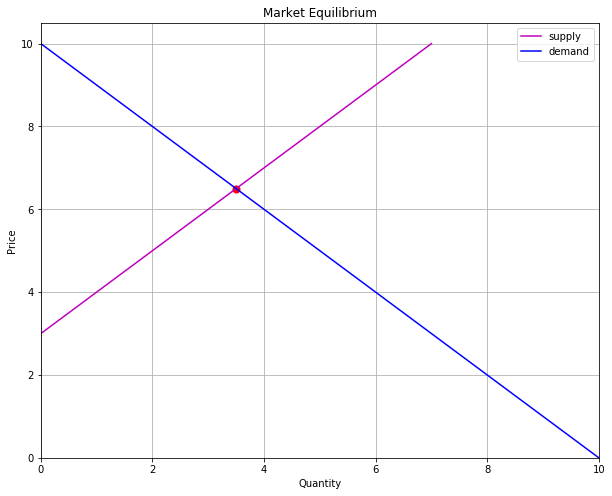

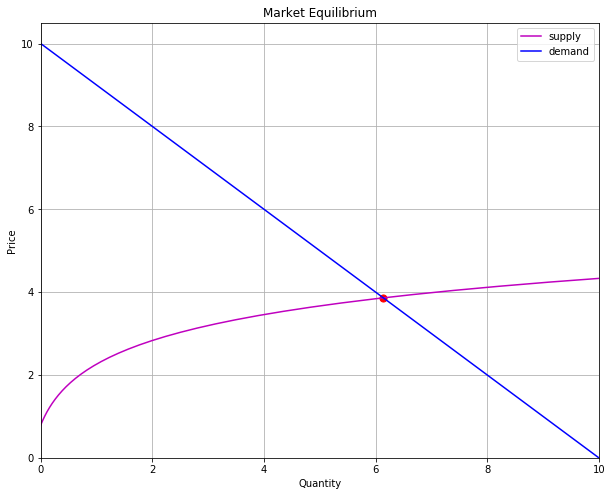

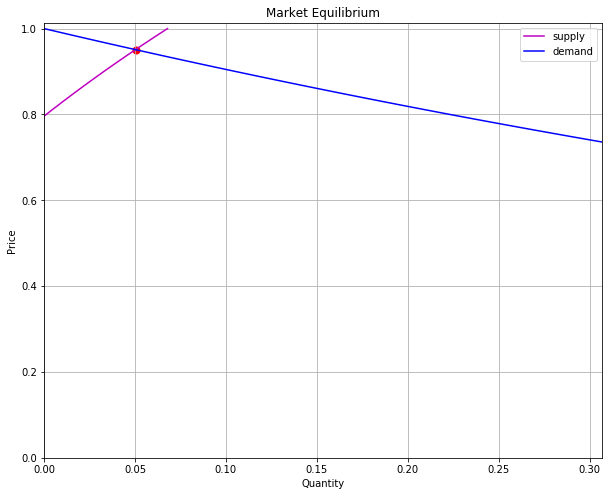

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class cobweb:
    '''
    This class holds the parameters of the cobweb model and implements the main functions.
    '''
    def __init__(self, params_supply, params_demand, funcform_supply='linear', funcform_demand='linear'):
        '''Initialize the model'''
        # check demand parameters and create demand and inverse demand functions
        if funcform_demand == 'linear':
            a,b = params_demand
            if a >= 0 :
                raise ValueError("Need negative slope for downward sloping demand")
            # add the methods demand(p) and invdemand(q) to the object
            self.demand = self.__implement_funcform(funcform_demand,a,b)
            self.invdemand = self.__implement_funcform(funcform_demand,a,b,inverse=True)
        elif funcform_demand in ['exp','log']:
            a, b, c, d = params_demand
            if a*b >= 0:
                raise ValueError("Need at least one negative slope for downward sloping demand")
            # add the methods demand(p) and invdemand(q) to the object
            self.demand = self.__implement_funcform(funcform_demand,a,b,c,d)
            self.invdemand = self.__implement_funcform(funcform_demand,a,b,inverse=True)
        else:
            raise ValueError("Unknown functional form for demand")
        # check supply parameters and create supply functionss
        if funcform_supply == 'linear':
            a,b = params_supply
            if a <= 0 :
                raise ValueError("Need positive slope for upwards sloping supply")
            # add the method supply(p) to the object
            self.supply = self.__implement_funcform(funcform_supply,a,b)
        elif funcform_supply in ['exp','log']:
            a, b, c, d = params_supply
            if (a <= 0) or (b <= 0):
                raise ValueError("Need positive slopes for upwards sloping supply")
            # add the method supply(p) to the object
            self.supply = self.__implement_funcform(funcform_supply,a,b,c,d)
        else:
            raise ValueError("Unknown functional form for supply")
        # save funcform info in the object
        self.funcform_demand = funcform_demand
        self.funcform_supply = funcform_supply

    def __repr__(self):
        '''Representation of the model object'''
        return 'Cobweb Model with %s demand and %s supply' % (self.funcform_demand, self.funcform_supply)

    def __implement_funcform(self,funcform,a,b,c=0,d=0,inverse=False):
        '''Helper method that returns a callable function for demand and supply'''
        if not inverse:
            if funcform == 'linear':
                return lambda x: a*x + b
            elif funcform == 'exp':
                return lambda x: a* np.exp(b*x+c) + d
            elif funcform == 'log':
                return lambda x: a* np.log(b*x+c) + d
        else:
            # inverse of the function
            if funcform == 'linear':
                return lambda y: (y-b)/a
            elif funcform == 'exp':
                return lambda y:  (np.log((y-d)/a)-c)/b
            elif funcform == 'log':
                return lambda y: (np.exp((y-d)/a)-c)/b

    def solve(self,lower=0, upper=100):
        '''Market equilibrium solver, using bisection method bounded on quantity'''
        # market equilibrium is given by the equation supply(invdemand(q))-q=0
        equation = lambda x: self.supply(self.invdemand(x))-x
        q = bisection(equation,lower,upper)
        p = self.invdemand(q)
        return p, q #return both equilibrium price and quantity

    def plot(self, lower=0, upper=100, ngrid=100):
        '''Method to plot demand and supply curves given quantity grid'''
        # set bounds for q (given) and p (computed)
        lower = max(0,lower) # use zero as updated lower bound
        upper = min(upper, self.demand(0)) # use demand at zero price as updated upper bound
        q = np.linspace(lower, upper, ngrid)
        p = np.linspace(max(0,min(self.invdemand(lower),self.invdemand(upper))), \
                        max(self.invdemand(lower),self.invdemand(upper)),ngrid)
        p0,q0 = self.solve() # market equilibrium
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.plot(self.supply(p),p,c='m',label='supply')
        ax.plot(q,self.invdemand(q),c='b',label='demand')
        ax.scatter(q0,p0,c='red',s=50)
        xlim = ax.set_xlim()
        ax.set_xlim(left=max(0,xlim[0]),right=min(upper,xlim[1]))
        ax.set_ylim(bottom=0)
        ax.set_title('Market Equilibrium')
        ax.set_xlabel('Quantity')
        ax.set_ylabel('Price')
        plt.grid()
        plt.legend()
        plt.show()

# run a few tests
m1 = cobweb((1, -3), (-1, 10), funcform_supply='linear', funcform_demand='linear')
m2 = cobweb((1, 1, -2, -.3), (-1, 10), funcform_supply='exp', funcform_demand='linear')
m3 = cobweb((1, 1, -2, -.3), (-1, 1,2,1), funcform_supply='exp', funcform_demand='log')
m1.plot(0,10)
m2.plot(0,10)
m3.plot(0,10)

### Task 2. Make a plotting function to produce the cobweb diagram

Write the function that would create the cobweb diagram starting from
an initial quantity *or* price, and plotting the first $ n $ iterations
of the model.
The same function should output the sequence of the prices and quantities.

In [3]:
def plotme_cobweb(model, p_init=1, a=0, b=100, T=3 , showresult=True, returnprice=False):
    """
    Make a cobweb plot:
    Plot Demand and Supply curves for a <= qty <= b, and illustrate the dynamics
    starting at p = p0.
    Arguments: model object, initial price, qmin, qmax, number of time periods/iterations.
    Returns list of quantities and prices from the iterations.
    """
    q = np.linspace(a, b, 100)

    #criteria
    if model.FuncFormDemand == 'exp': ## exp demand is special as we need inverse demand function,
        criteriaD = (model.params_demand[3] - q) / model.params_demand[0] < 0
    else:
        criteriaD = [True] * len(q)

    if model.FuncFormSupply == 'exp': ## exp demand is special as we need inverse demand function,
        criteriaS = (q - model.params_supply[3]) / model.params_supply[0] > 0
    elif model.FuncFormSupply == 'quadratic':
        criteriaS = (model.params_supply[1] ** 2 - 4 * model.params_supply[2] * (q-model.params_supply[0]) > 0)
    else:
        criteriaS = [True] * len(q)

    # Plot Inverse Demand and Inverse Supply curves and eqm

    fig, ax = plt.subplots(figsize=(10, 8))
    supply = polyline(q[criteriaS], model.invsupply(q[criteriaS]), 'Supply')
    demand = polyline(q[criteriaD], model.invdemand(q[criteriaD]), 'Demand')
    eqm = demand.intersect(supply)
    demand.plot(c='k')
    supply.plot(c='m')
    if len(eqm) > 0:
            for ieqm in eqm:
                ax.scatter(eqm[:, 0], eqm[:, 1], c='r', s=120)
                ax.annotate('(Q*=%1.2f, P*=%1.2f)' % tuple(ieqm), xy=ieqm, \
                            textcoords='offset points', xytext=(15,5))

    #Trace out path
    p0 = p_init
    Price = [p0]
    Quantity = []
    q0 = model.demand(p0)
    Quantity.append(q0)
    for t in range(T):
        q0 = model.demand(p0)
        q1=model.supply(p0); Quantity.append(q1)
        p1=model.invdemand(q1); Price.append(p1)
        q2 = model.supply(p1); Quantity.append(q2)
        p2=model.invdemand(q2); Price.append(p2)
        ax.hlines(y=p0, xmin=q0, xmax=q1, colors='r', linestyle=':')   #first line; hline
        ax.vlines(x=q1, ymin=p1, ymax=p0, colors='b', linestyle=':')   #second line; vline
        ax.hlines(y=p1, xmin=q2, xmax=q1, colors='g', linestyle=':')   #third line, hline
        ax.vlines(x=q2, ymin=p1, ymax=p2, colors='c', linestyle=':')   #fourth line; vline
        p0 = p2

    # collect results into a list
    result = list(zip(Quantity, Price))
    # Annotate and tidy the plot.
    ax.minorticks_on()
    ax.grid(which='major', alpha=0.5)
    ax.set_title('Cobweb Plot')
    ax.set_ylabel('Price')
    ax.set_xlabel('Quantity')
    ax.legend()
    ax.set_title('$p_0 = {:.2}, T = {:1}$'.format(p_init, T))
    plt.show()

    if returnprice == True:
        return Price

    if showresult == True:
        print(model)
        print('Initial price: $%d' % (p_init) )
        print('Number of iterations: %d' % (T) )
        print('(Quantity,Price):')
        return result

### Task 3. Illustrate the types of behavior of the model

Find parameter values to illustrate the convergent and divergent dynamics of the model.

- Use the linear supply and demand curves first to illustrate the two
  cases  
- Then derive (analytically) the parameters of the exponential and the logarithmic
  curves such that their derivatives at the equilibrium (intersection)
  point are the same as those of the linear curves  
- Compare the convergence dynamics of the linear case to the four
  combinations of non-linear supply and demand curves:
  - exp - exp specification respectively for demand and supply
  - exp - log specification respectively for demand and supply
  - log - exp specification respectively for demand and supply
  - log - log specification respectively for demand and supply  

### Task 4. Develop function to illustrate model dynamics

This function should take model object as one input, with the second input
being the list of sets of model parameters that specify a sequence of supply
and demand specifications.
The function should produce a sequence of plots with time on the x axes to
compare price or quantity fluctuations between the specifications.

- Use already written code as much as possible, it’s better to modify the
  existing code a little rather than copying it  
- Make all the plots to be part of the same figure using *subplot* command  
- Make sure to keep the same scale on all the plots  


Run the specifications that you have selected in Task 3.
Compare the price dynamics between all cases.

### Task 5. Cycles

Derive the analytical conditions for a cyclical dynamic to appear in a linear specification
of the model.

Then derive a similar condition for one non-linear specification from Task 3.

- Solve the resulting equation using one of the algorithm from week 6 assignments for the chosen
  model specification  
- Write a function that would take a cobweb model object as an argument, and produce a diagram
  with the circular dynamic of the price and quantities.  